# <center>Итоговый проект первого года обучения Skillfactory Data Science

# <center>Определение уязвимых групп населения

## <center> 4. Кластеризация

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn import cluster, metrics
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим обработанный датасет

In [6]:
df = pd.read_csv(
    'social_russia_data/df_eda.csv', index_col='region')
display(df.head())

,child_mortality_percent,general_morbidity,congenital_malformation,psychosis,teenage_pregnancy,poverty_percent,welfare_expense_share,real_incomes,real_pay,living area,...,no funds,population,grp,reg_prod_total,retail,newborn_per_population,disabled_percent,all crimes,alco,drug
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,0.395807,112764.7,5.303802,1272.1,1.458615,17.5,29.7,4.569543,103.8,2.944439,...,0.622832,14.655850,12.581621,5.910482,11.942146,0.621701,1.294413,9.698184,88.1,2.912351
Амурская область,0.428418,83412.0,5.916472,446.7,1.686399,15.2,21.7,4.618086,105.2,2.906901,...,0.729045,13.579845,13.255780,6.240458,12.409968,0.690140,1.428663,8.769196,113.3,3.234749
Архангельская область без Ненецкого АО,0.281883,99842.1,6.131009,685.3,2.694627,12.3,21.4,4.599152,102.9,2.884801,...,0.832822,13.903911,13.150370,6.411688,12.429352,0.596224,1.244184,8.870803,64.7,2.322388
Астраханская область,0.461571,64679.9,6.030926,624.5,0.000000,15.6,31.4,4.585987,104.5,3.005683,...,1.361694,13.821277,13.174865,6.581238,12.069840,0.734686,1.079148,8.655040,22.2,0.182322
Белгородская область,0.322450,74637.4,4.921440,388.2,0.000000,7.2,16.1,4.596129,104.8,2.933857,...,0.324978,14.253218,13.379437,7.137797,12.376140,0.586308,1.593168,8.480322,41.3,1.435085


После обработки датасет содержит следующие признаки:

| Название признака | Описание | Единица измерения | Период |
|-|-|-|-|
| child_mortality_percent | Число умерших на первом году жизни детей за год по отношению к числу родившихся| % | 2020 |
| general_morbidity, congenital_malformation, psychosis, teenage_pregnancy | Общая заболеваемость, врожденные пороки развития, психические расстройства, подростковая беременность | кол-во. / 100 тыс. населения | 2016 |
| poverty_percent | Процент населения за чертой бедности | %  | 2020 |
| welfare_expense_share | Расходы на социальную политику от общих расходов бюджета региона | % | 2020 |
| real_incomes | Реальные денежные доходы (покупательная способность: с учетом роста цен) | процент к предыдущему году | 2020 |
| real_pay | Реальная начисленная заработная плата (покупательная способность: с учетом роста цен) | процент к предыдущему году | 2020 |
| living area | Жилищные условия: средняя жилая площадь на одного человека | кв.м. | 2020 |
| bad conditions | Жилищные условия: процент домохозяйств, указавших на плохое состояние жилого помещения | % | 2020 |
| no funds | Жилищные условия: процент домохозяйств, не имеющих средств для улучшения жилищных условий | % | 2020 |
| population | Население | чел. | 2020 |
| grp | Валовый региональный продукт на душу населения | руб. / чел. | 2020 |
| reg_prod_total | Региональное производство по отношению к численности населения | тыс. руб/чел | 2020 |
| retail | Розничная торговля | руб. / чел. | 2020 |
| newborn_per_population | Рождаемость по отношению к численности населения | % | 2020 |
| disabled_percent | Инвалидность по отношению к численности населения | % | 2020 |
| all crimes | Данные о преступлениях (общее количество) | Кол-во | 2020 |
| alco| Сведения о заболеваемости алкоголизмом | кол-во. / 100 тыс. населения | 2018 |
| drug | Сведения о заболеваемости наркоманией | кол-во. / 100 тыс. населения | 2018 |

### 4.1 Масштабирование признаков

Поскольку большинство признаков имеют распределение, отличное от нормального, а также в данных присутствуют выбросы, мы используем нормализацию методом RobustScaler.

In [7]:
# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df.columns)

scaler = RobustScaler()
df_r = scaler.fit_transform(df)

# Преобразуем датасет в полноценный датафрейм
df_r = pd.DataFrame(df_r, columns=col_names, index=df.index)

display(df_r.describe())

,child_mortality_percent,general_morbidity,congenital_malformation,psychosis,teenage_pregnancy,poverty_percent,welfare_expense_share,real_incomes,real_pay,living area,...,no funds,population,grp,reg_prod_total,retail,newborn_per_population,disabled_percent,all crimes,alco,drug
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.111243,0.110886,-0.020559,0.120687,-0.025463,0.110407,-0.139742,0.098285,0.157516,0.053676,...,0.143937,-0.006334,0.151333,-0.095346,-0.093582,0.128785,0.136241,-0.003022,0.129795,-0.007859
std,0.831219,0.760360,0.717455,0.879107,0.578815,0.970386,1.277519,0.888942,1.113088,0.925431,...,0.601387,0.841361,1.213442,1.074128,0.911316,1.064087,1.057853,0.868068,1.026318,0.943941
min,-1.518088,-1.423333,-1.835010,-1.560808,-0.646673,-1.634615,-4.170732,-2.035512,-2.555556,-1.588185,...,-0.472592,-2.842664,-2.214176,-3.608318,-3.931215,-1.321554,-1.912328,-2.767448,-1.801775,-2.830376
25%,-0.424319,-0.454554,-0.515297,-0.419000,-0.646673,-0.557692,-0.463415,-0.423141,-0.444444,-0.494288,...,-0.472592,-0.398805,-0.556787,-0.520585,-0.515993,-0.563024,-0.524560,-0.413564,-0.467456,-0.464508
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.575681,0.545446,0.484703,0.581000,0.353327,0.442308,0.536585,0.576859,0.555556,0.505712,...,0.527408,0.601195,0.443213,0.479415,0.484007,0.436976,0.475440,0.586436,0.532544,0.535492
max,4.662792,2.650421,1.784108,3.790730,1.878735,3.538462,2.829268,3.750305,4.666667,3.706467,...,1.656745,2.078706,4.567208,2.768653,2.113323,4.230278,4.303252,1.368040,4.366864,2.659050


Признаки были приведены к единой размерности

### 4.2. Базовая модель: k-means

В качестве базовой модели используем k-means. Выбираем количество кластеров

In [8]:
def plot_metrics(X):
    """
    Отображение метрик кластеризации методом K-Means
    в зависимости от количества кластеров
    """
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 16})
    ax[1].legend(prop={'size': 16})
    ax[2].legend(prop={'size': 16})
    ax[3].legend(prop={'size': 16});
    fig.supxlabel('Количество кластеров')

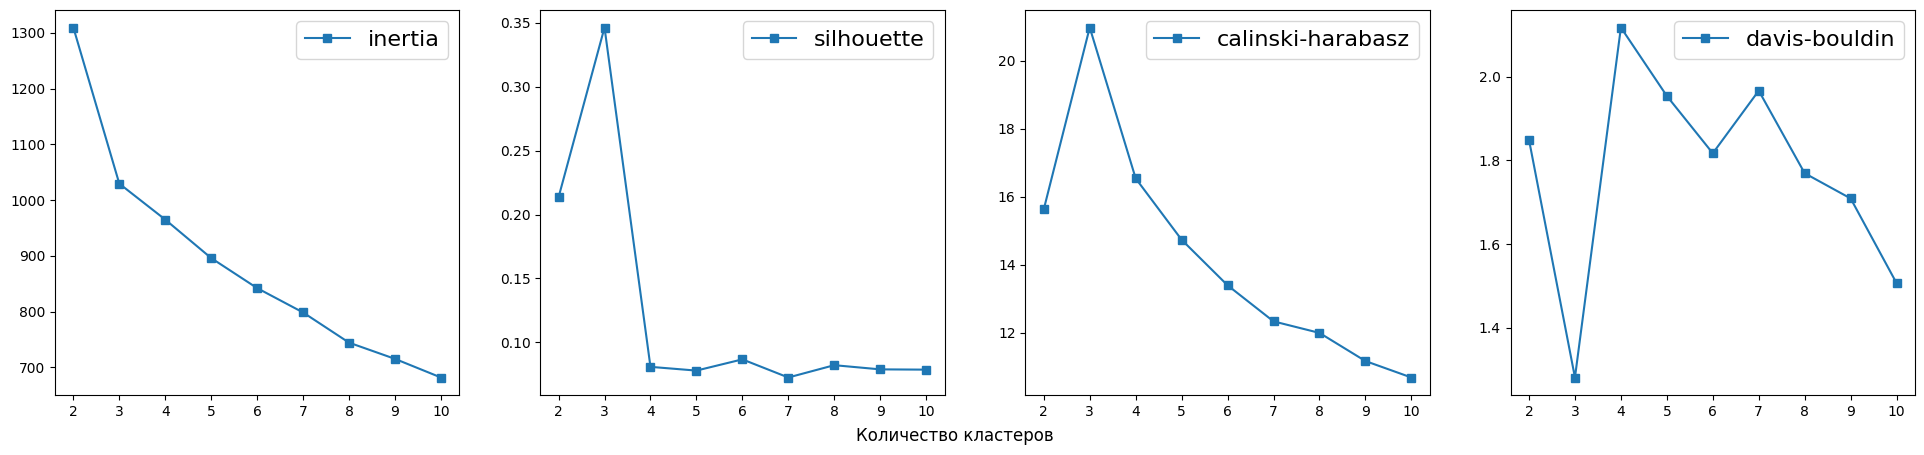

In [9]:
plot_metrics(df_r)

Разделение кластеров нечеткое (коэффициент силуэта везде меньше 0.4, наибольшее значение при количестве кластеров 3). Ориентируясь на значение метрик коэффициента силуэта, индекса Калински-Харабаса и индекса Дэвиса-Болдина, можно принять количество кластеров $n = 3$

В качестве графического представления результатов кластеризации используем t-SNE преобразование пятимерного признакового пространства на плоскость. Выводим значения метрик качества кластеризации.

In [10]:
def plot_2D_clusters(data, labels):
    """
    Построение двумерной проекции результатов кластеризации методом t-SNE
    и вывод полученных метрик
    """
    tsne = TSNE(n_components=2, perplexity=50, init='pca',
                learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(data))
    df_tsne['cluster'] = labels
    fig = plt.figure()
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1],
                    hue=df_tsne['cluster'], palette='bright')
    fig.suptitle('Двумерная проекция результатов кластеризации', fontsize=14);

    print(f'Коэфициент силуэта: {metrics.silhouette_score(data, labels):.3f}')
    print(f'Коэфициент Калински-Харабаса: {metrics.calinski_harabasz_score(data, labels):.3f}')
    print(f'Коэфициент Дэвиса-Болдина: {metrics.davies_bouldin_score(data, labels):.3f}')

Коэфициент силуэта: 0.346
Коэфициент Калински-Харабаса: 20.981
Коэфициент Дэвиса-Болдина: 1.282


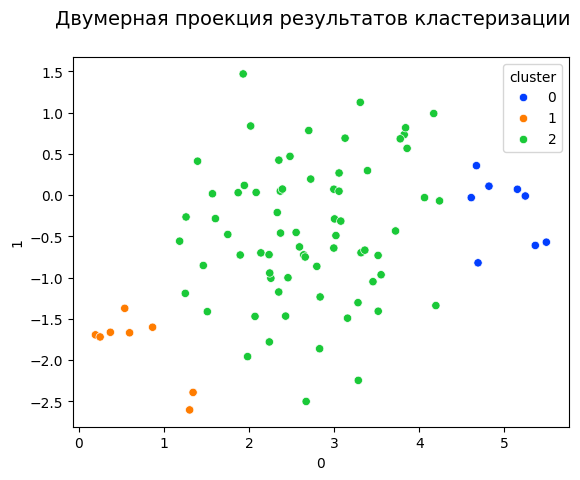

In [11]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
bm_labels = kmeans.fit_predict(df_r)
plot_2D_clusters(df_r, bm_labels)

### 4.3 Понижение размерности методом PCA (кластеризация - k-means)

Число главных компонент: 11


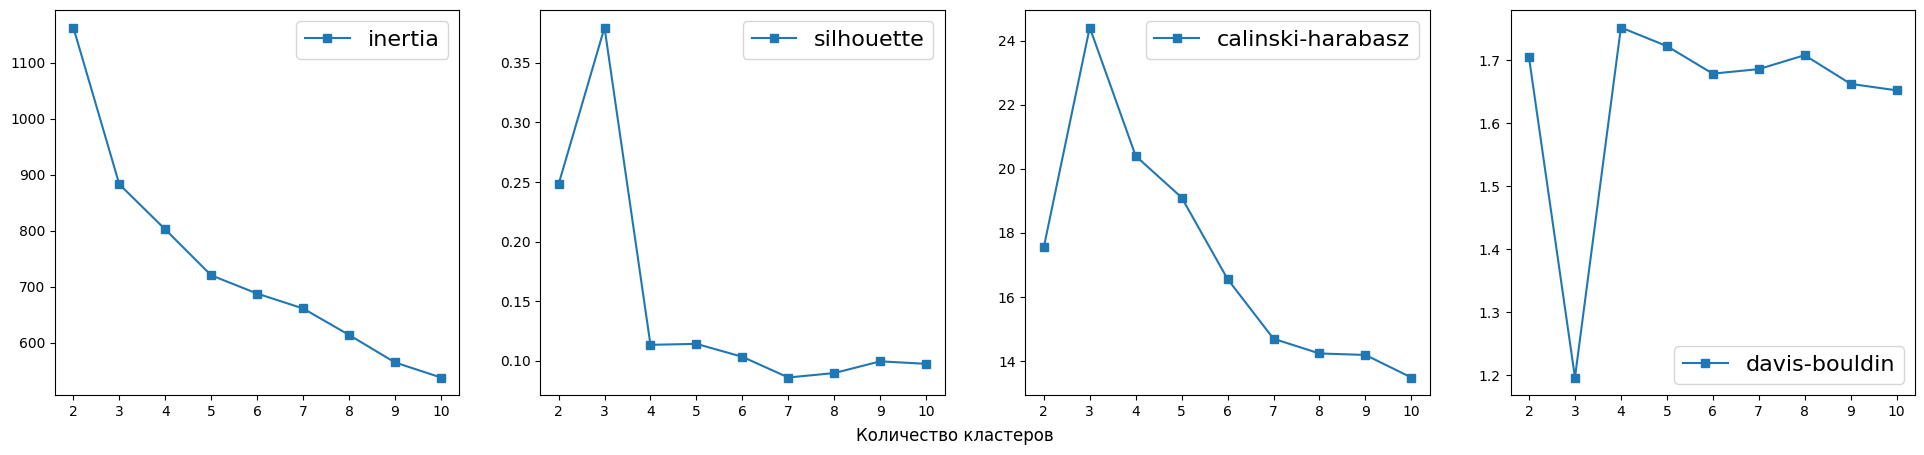

In [12]:
pca = PCA(n_components=0.9)  # 90% of explained dispersion
df_pca = pca.fit_transform(df_r)
print(f'Число главных компонент: {pca.n_components_}')

plot_metrics(df_pca)

Метрики по прежнему показывают наилучшее количество кластеров $n = 3$

Коэфициент силуэта: 0.380
Коэфициент Калински-Харабаса: 24.415
Коэфициент Дэвиса-Болдина: 1.197
Индекс Рэнда (сравнение с базовой моделью): 1.000000


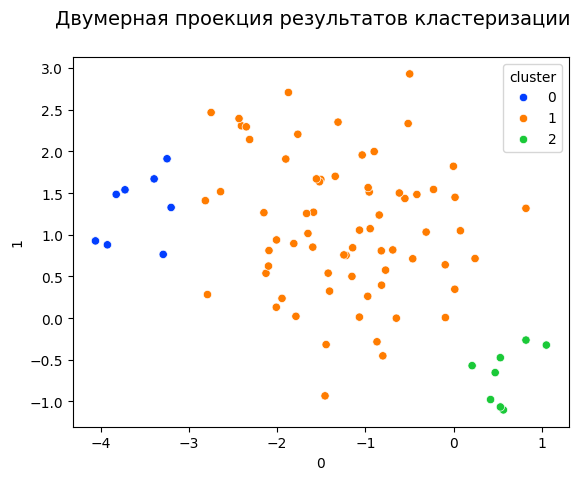

In [13]:
kmeans_pca = cluster.KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit_predict(df_pca)
plot_2D_clusters(df_pca, kmeans_pca.labels_)
print(f'Индекс Рэнда (сравнение с базовой моделью): {metrics.rand_score(bm_labels, kmeans_pca.labels_):3f}')

В целом, распределение кластеров не изменилось, индекс Рэнда равен 1. При этом произошло незначительное улучшение метрик кластеризации (коэфициента силуэта, коэфициента Калински-Харабаса и коэфициента Дэвиса-Болдина).